In [144]:
import scanpy
import scprep
import phate
import pandas as pd
import numpy as np
from DiffusionEMD import DiffusionCheb
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import cdist,pdist,squareform
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [105]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')
all_adatas = scanpy.read_h5ad('results/all_mapped_human_datasets.h5ad')

In [106]:
metadata = pd.read_csv('results/metadata.csv', index_col=0)

In [107]:
all_adatas.obsm['X_scmmgan_gene'] = pd.DataFrame(all_adatas.obsm['X_scmmgan_gene'],
                                                 index=all_adatas.obs_names,
                                                 columns=adata_beta.var['names'])

In [108]:
all_adatas.obs['sample'].value_counts()

sample
GSE101207    9958
GSE81608      354
GSE86469      230
GSE154126      91
GSE83139       30
Name: count, dtype: int64

Due to imbalance in number of cells between datasets, we will build a graph based on all cells mapping and plot sample embedding

In [109]:
phate_op = phate.PHATE(random_state=42, verbose=False)
data_phate = phate_op.fit_transform(all_adatas.obsm['X_scmmgan_pca'])

In [110]:
adj = phate_op.graph.to_pygsp().A

In [111]:
enc_op = OneHotEncoder()
distributions = np.array(enc_op.fit_transform(X=all_adatas.obs[['full_ID']]).todense())
donors = enc_op.categories_[0]

In [112]:
metadata = metadata.loc[donors]

In [113]:
distributions = distributions / distributions.sum(axis=0)

In [114]:
dc = DiffusionCheb()
# Embeddings where the L1 distance approximates the Earth Mover's Distance
embeddings = dc.fit_transform(adj, distributions)

In [115]:
distances = squareform(pdist(embeddings, metric='cityblock'))

In [116]:
patient_phate_op = phate.PHATE(random_state=42, knn_dist='precomputed_distance')
patient_data_phate = patient_phate_op.fit_transform(distances)

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 24 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 8
  Calculating diffusion potential...
  Calculating metric MDS...


<Axes: >

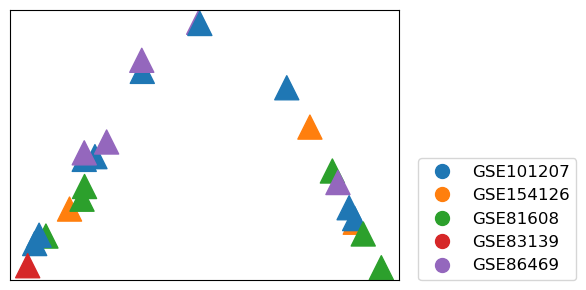

In [117]:
scprep.plot.scatter2d(patient_data_phate, c=metadata['sample'], ticks=None, marker='^', s=300,
                      figsize=(6,3),
                      legend_loc=(1.05, 0), filename='figures/patient_manifold.png', dpi=300)

In [118]:
patient_INS = all_adatas.obs.groupby('full_ID').mean('INS').loc[donors]['INS']

<Axes: >

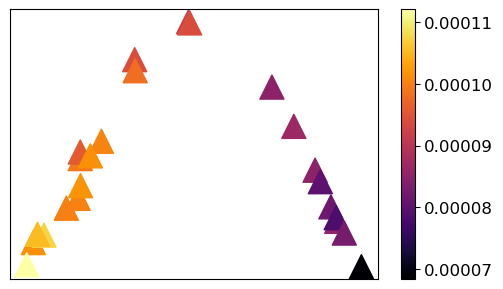

In [119]:
scprep.plot.scatter2d(patient_data_phate, c=patient_INS, ticks=None, marker='^', s=300,
                      figsize=(5.2,3),
                      legend_loc=(1.05, 0), filename='figures/patient_INS.png', dpi=300)

In [122]:
metadata['INS'] = patient_INS

In [123]:
ev = patient_phate_op.graph.to_pygsp().U[:, 1]

2024-08-12 11:33:28,622:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


In [138]:
attributes_of_interest = ['age', 'BMI', 'HbA1c', 'isT2D', 'isMale', 'INS']

In [142]:
for attribute in attributes_of_interest:
    mask = ~metadata[attribute].isnull()
    print(attribute, pearsonr(ev[mask], metadata[attribute][mask]).statistic)

age 0.28167960373205425
BMI -0.18167542918175988
HbA1c 0.5024575589856588
isT2D 0.4926231122820483
isMale -0.17293615950632482
INS -0.9278483263987816


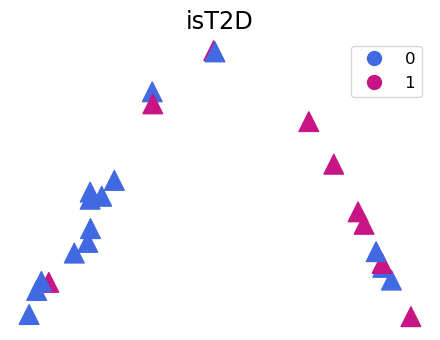

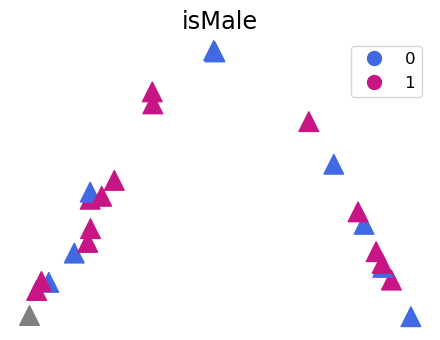

In [159]:
for attribute in ['isT2D', 'isMale']:
    fig, ax = plt.subplots(figsize=(4.5,3.5))
    scprep.plot.scatter2d(patient_data_phate, ticks=None, mask=metadata[attribute].isnull(), c='gray', ax=ax, marker='^', s=200)
    scprep.plot.scatter2d(patient_data_phate[~metadata[attribute].isnull()],
                          ticks=None, c=metadata[attribute][~metadata[attribute].isnull()].astype(int), ax=ax, title=attribute,
                          discrete=True, marker='^', s=200,
                          cmap={0: 'royalblue', 1: 'mediumvioletred'})
    plt.tight_layout()
    ax.axis('off')
    fig.savefig(f'figures/{attribute}_patient_manifold.png', dpi=300)

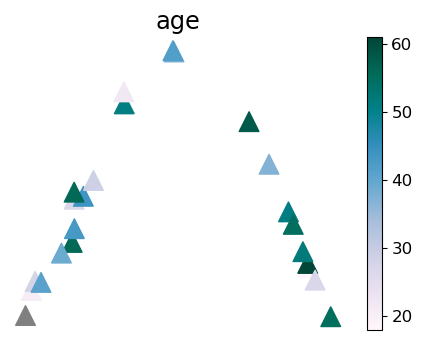

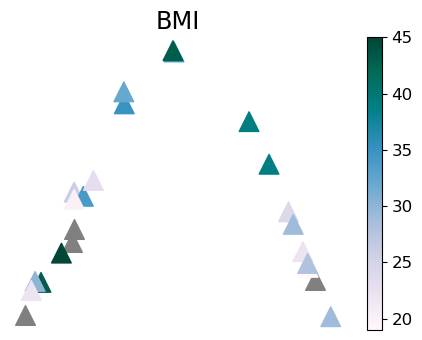

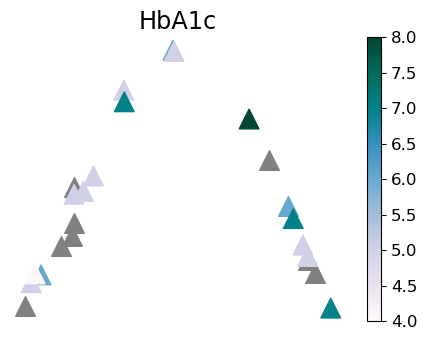

In [163]:
for attribute in ['age', 'BMI', 'HbA1c']:
    fig, ax = plt.subplots(figsize=(4.5,3.5))
    scprep.plot.scatter2d(patient_data_phate, ticks=None, mask=metadata[attribute].isnull(), c='gray', ax=ax, marker='^', s=200)
    scprep.plot.scatter2d(patient_data_phate[~metadata[attribute].isnull()],
                          ticks=None, c=metadata[attribute][~metadata[attribute].isnull()].astype(int), ax=ax, title=attribute,
                          marker='^', s=200, cmap='PuBuGn', discrete=False)
    plt.tight_layout()
    ax.axis('off')
    fig.savefig(f'figures/{attribute}_patient_manifold.png', dpi=300)